<br/>

$$ \huge{\underline{\textbf{ Playing Atari Games with Deep RL }}} $$

$$ \large{\textbf{MountainCar + DQN + Memory Reply}} $$

<br/>



In [1]:
def ep_semi_grad_sarsa(env, ep, gamma, eps, q_hat, mem, callback=None, trace=None):
    """Episodic Semi-Gradient Sarsa
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        q_hat      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
    """
    def policy(st, q_hat, eps):
        if np.random.rand() > eps:
            q_values = q_hat.eval(st)
            return argmax_rand(q_values)
        else:
            return np.random.choice(env.act_space)
        
    # skip weight intialization, 
    
    for e_ in range(ep):
        S = env.reset()
        A = policy(S, q_hat, eps)
        for t_ in range(10**100):       
            S_, R, done = env.step(A)
            
            mem.append(S, A, R, S_, done)
            
            if done:
                q_hat.train(S, A, R)
                break
                
            A_ = policy(S_, q_hat, eps)
            target = R + gamma * q_hat.eval(S_)[A_]
            q_hat.train(S, A, target)
            S, A = S_, A_
                
            if callback is not None:
                callback(e_, t_, S, A, q_hat, mem, trace)

Tile Coding - see [chapter 9.5](0905b_LM_Agg_Tile.ipynb) for introduction

In [2]:
class TileCodingFuncApprox():
    def __init__(self, st_low, st_high, action_space, learn_rate, num_tilings, init_val):
        """
        Params:
            st_low       - state space low boundry, e.g. [-1.2, -0.07] for mountain car
            st_high      - state space high boundry in all dimensions
            action_space - list of possible actions
            learn_rate   - step size, will be adjusted for nb_tilings automatically
            num_tilings  - tiling layers - should be power of 2 and at least 4*len(st_low)
            init_val     - initial state-action values
        """
        assert len(st_low) == len(st_high)
        self._n_dim = len(st_low)
        self._act_space = action_space
        self._lr = learn_rate / num_tilings
        self._num_tilings = num_tilings
        self._scales = self._num_tilings / (st_high - st_low)
        
        # e.g. 8 tilings, 2d space, 3 actions
        # nb_total_tiles = (8+1) * (8+1) * 8 * 3
        nb_total_tiles = (num_tilings+1)**self._n_dim * num_tilings * len(action_space)
                
        self._iht = tiles3.IHT(nb_total_tiles)
        self._weights = np.zeros(nb_total_tiles) + init_val / num_tilings
        
    def eval(self, state):
        assert len(state) == self._n_dim
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        q_values = []
        for action in self._act_space:
            active_tiles = tiles3.tiles(                 # find active tiles
                self._iht, self._num_tilings,
                scaled_state, [action])
            q_val = np.sum(self._weights[active_tiles])  # pick correct weights and sum up
            q_values.append(q_val)                       # store result for this action
        return q_values

    def train(self, state, action, target):
        assert len(state) == self._n_dim
        assert np.isscalar(action)
        assert np.isscalar(target)
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles3.tiles(                     # find active tiles
            self._iht, self._num_tilings,
            scaled_state, [action])
        value = np.sum(self._weights[active_tiles])      # q-value for state-action pair
        delta = self._lr * (target - value)              # grad is [0,1,0,0,..]
        self._weights[active_tiles] += delta             # ..so we pick active weights instead

Helper functions

In [3]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

---

# Solve Mountain Car

Imports (source file: [tiles3.py](tiles3.py), [helpers_1001.py](helpers_1001.py))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
from collections import OrderedDict
from mountain_car import MountainCarEnv
import tiles3           # by Richard Sutton, http://incompleteideas.net/tiles/tiles3.html

Environment

In [5]:
env = MountainCarEnv()

Create function approximator and solve

In [ ]:
q_hat = TileCodingFuncApprox(env.state_low, env.state_high, len(env.act_space),
                             learn_rate=0.3, num_tilings=8, init_val=0)
ep_semi_grad_sarsa(env, ep=100, gamma=1.0, eps=0.0, q_hat=q_hat)

Plot

In [ ]:
q_arr = eval_state_action_space(q_hat, env)
plot_q_max_3d(q_arr, env, labels=['Position', 'Velocity', ''], alpha=0.4)

# Recreate figure 10.1

We will need callback to capture q-value array for whole state-action space at specified episodes.

In [6]:
import pdb

In [7]:
class Trace():
    def __init__(self):
        
        self.q_values_at_episode = OrderedDict()
        
        self.state_hist_at_episode = OrderedDict()
        self.action_hist_at_episode = OrderedDict()
        
        self.total_rewards = []
        
        # self.total_reward_at_episode = OrderedDict()
        

In [8]:
def callback(episode, tstep, st, act, model, memory, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    
    
    if episode % 100 == 0 and tstep == 0:
        q_arr = eval_state_action_space(q_hat, env)
        trace.q_values_at_episode[episode] = q_arr
        
        states, actions, _, _, _, _ = mem.pick_last_episode()
        trace.state_hist_at_episode[episode] = states
        trace.action_hist_at_episode[episode] = actions
        
        print(episode)
    
    if tstep == 0:
        trace.total_rewards.append(0)
    trace.total_rewards[-1] = tstep


In [15]:
trace = Trace()
q_hat = TileCodingFuncApprox(env.state_low, env.state_high, env.act_space,
                             learn_rate=0.3, num_tilings=8, init_val=0)
mem = Memory(max_len=10000, state_shape=(2,), state_dtype=float)
ep_semi_grad_sarsa(env, ep=1005, gamma=1.0, eps=0.0, q_hat=q_hat, mem=mem,
                   callback=callback, trace=trace)

0
100
200
300
400
500
600
700
800
900
1000


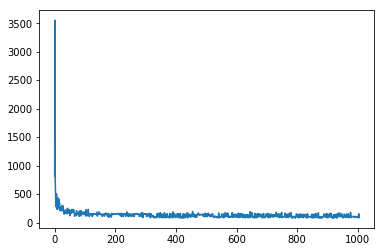

In [16]:
plt.plot(trace.total_rewards)

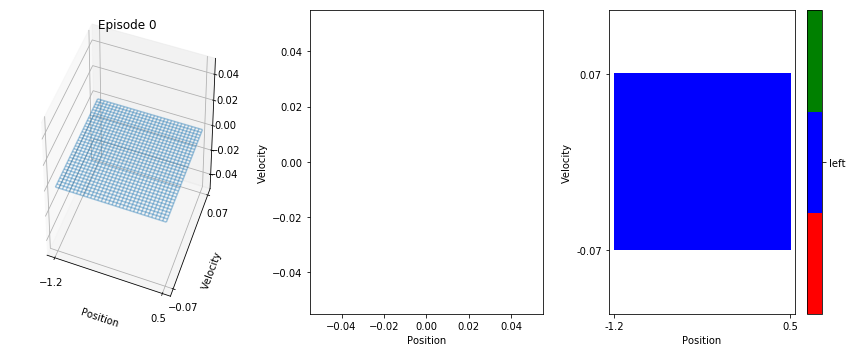

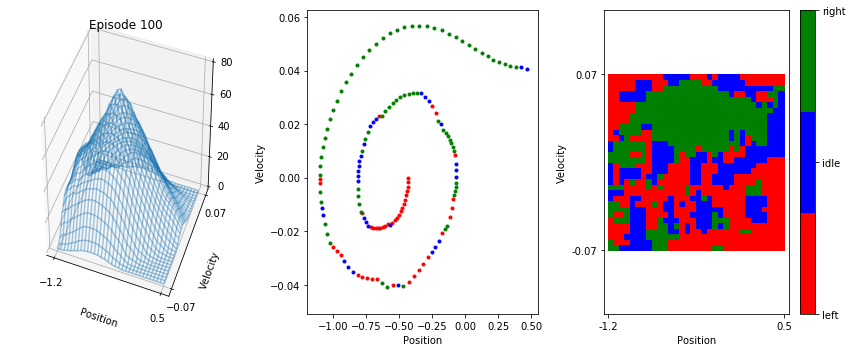

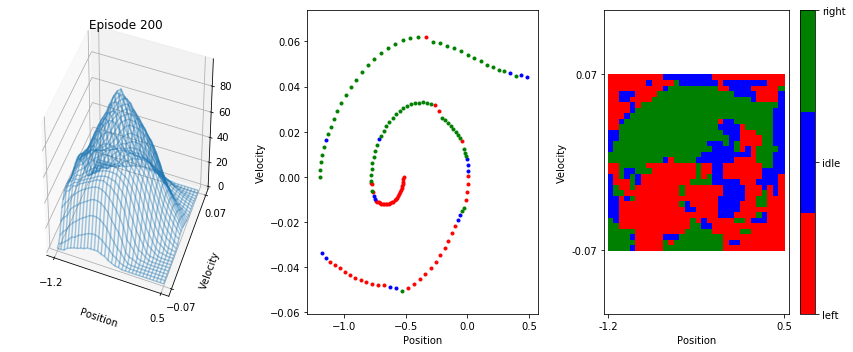

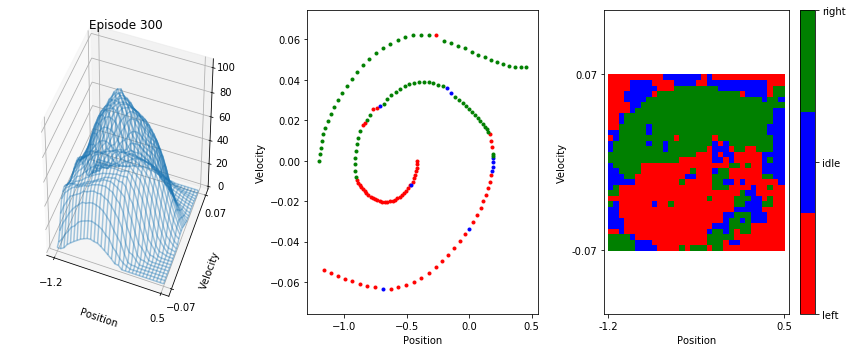

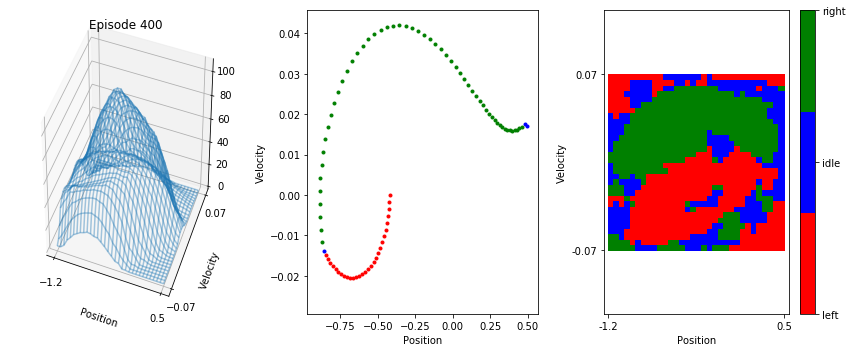

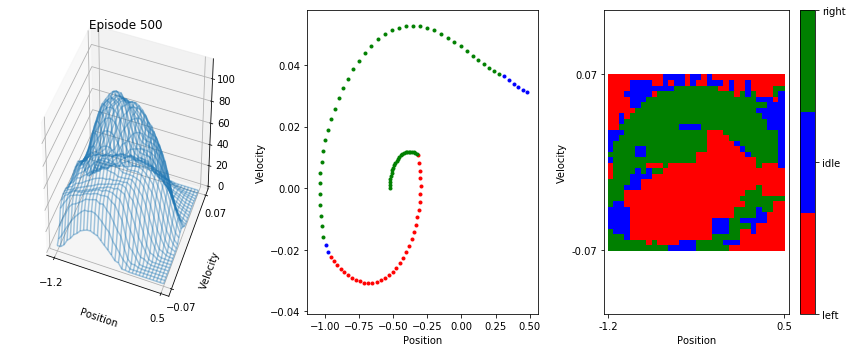

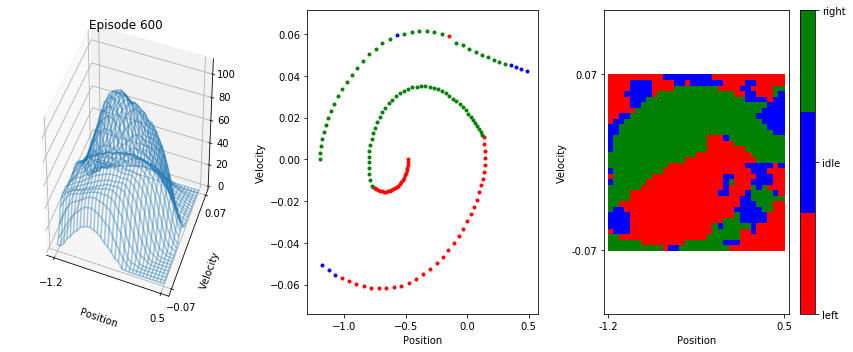

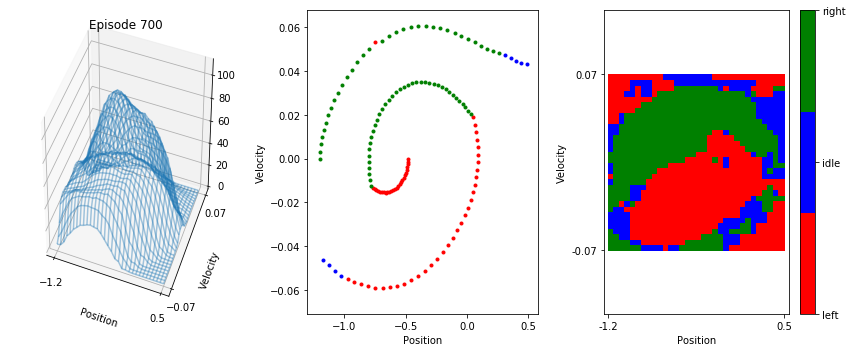

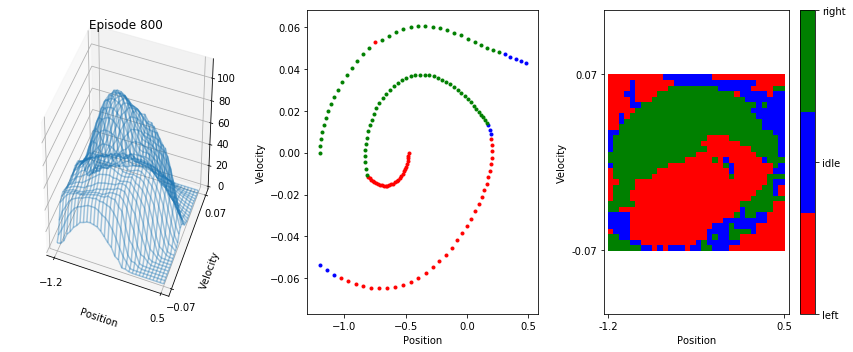

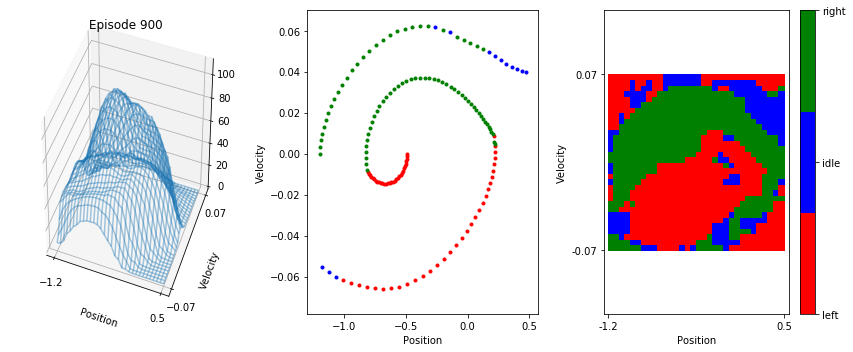

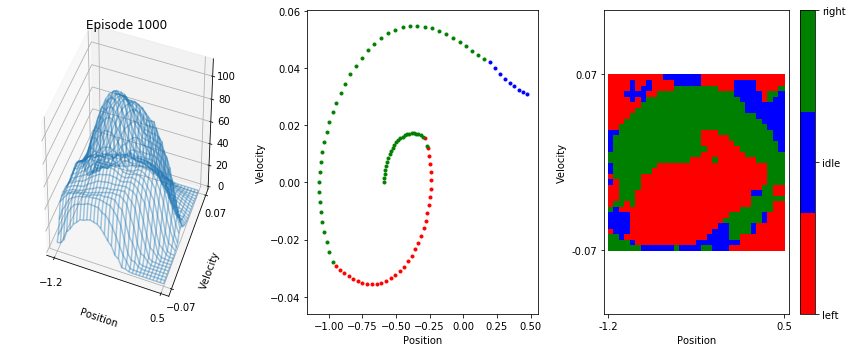

In [23]:
for ep_nb, q_val in trace.q_values_at_episode.items():
    states = trace.state_hist_at_episode[ep_nb]
    actions = trace.action_hist_at_episode[ep_nb]
    
    plot_mountain_car(q_val, states, actions, env, episode=ep_nb)

---

# Appendix - function definitions

In [9]:
class Memory:
    """Circular buffer for DQN memory reply. Fairly fast."""

    def __init__(self, max_len, state_shape, state_dtype):
        """
        Args:
            max_len: maximum capacity
            state_space: gym.spaces.Box (tested) or Discrete (not tested)
            action_space: gym.spaces.Box (not tested) or Discrete (tested)
        """
        assert isinstance(max_len, int)
        assert max_len > 0

        self._max_len = max_len                            # maximum length        
        self._curr_insert_ptr = 0                          # index to insert next data sample
        self._curr_len = 0                                 # number of currently stored elements

        state_arr_shape = [self._max_len] + list(state_shape)

        self._hist_St = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_At = np.zeros(self._max_len, dtype=int)
        self._hist_Rt_1 = np.zeros(self._max_len, dtype=float)
        self._hist_St_1 = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_done = np.zeros(self._max_len, dtype=bool)

    def append(self, St, At, Rt_1, St_1, done):
        """Add one sample to memory, override oldest if max_len reached.

        Args:
            St [np.ndarray]   - state
            At [int]          - action
            Rt_1 [float]      - reward
            St_1 [np.ndarray] - next state
            done [bool]       - True if episode completed
        """
        self._hist_St[self._curr_insert_ptr] = St
        self._hist_At[self._curr_insert_ptr] = At
        self._hist_Rt_1[self._curr_insert_ptr] = Rt_1
        self._hist_St_1[self._curr_insert_ptr] = St_1
        self._hist_done[self._curr_insert_ptr] = done
        
        if self._curr_len < self._max_len:                 # keep track of current length
            self._curr_len += 1
            
        self._curr_insert_ptr += 1                         # increment insertion pointer
        if self._curr_insert_ptr >= self._max_len:         # roll to zero if needed
            self._curr_insert_ptr = 0

    def __len__(self):
        """Number of samples in memory, 0 <= length <= max_len"""
        return self._curr_len

    def get_batch(self, batch_len):
        """Sample batch of data, with repetition

        Args:
            batch_len: nb of samples to pick

        Returns:
            states, actions, rewards, next_states, done, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert self._curr_len > 0
        assert batch_len > 0

        # np.random.randint much faster than np.random.sample
        indices = np.random.randint(
            low=0, high=self._curr_len, size=batch_len, dtype=int)

        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones = np.take(self._hist_done, indices, axis=0)

        return states, actions, rewards_1, states_1, dones, indices

    def pick_last_episode(self):
        
        states, actions, rewards_1, states_1, dones, indices = self.pick_last(self._curr_len)

        end_of_episode_indices = np.nonzero(dones)[0]
        if len(end_of_episode_indices) >= 2:
            current_episode_last_step = end_of_episode_indices[-1]
            previous_episode_last_step = end_of_episode_indices[-2]
        else:
            return np.array([]), np.array([]), np.array([]), \
                   np.array([]), np.array([]), np.array([])
        
        states = states[previous_episode_last_step+1 : current_episode_last_step+1]
        actions = actions[previous_episode_last_step+1 : current_episode_last_step+1]
        rewards_1 = rewards_1[previous_episode_last_step+1 : current_episode_last_step+1]
        states_1 = states_1[previous_episode_last_step+1 : current_episode_last_step+1]
        dones = dones[previous_episode_last_step+1 : current_episode_last_step+1]
        indices = indices[previous_episode_last_step+1 : current_episode_last_step+1]
        
        return states, actions, rewards_1, states_1, dones, indices
    
    def pick_last(self, nb):
        """Pick last nb elements from memory
        
        Returns:
            states, actions, rewards, next_states, done, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert nb <= self._curr_len
        
        start = self._curr_insert_ptr - nb                # inclusive
        end = self._curr_insert_ptr                       # not inclusive
        indices = np.array(range(start,end), dtype=int)   # indices to pick, can be negative
        indices[indices < 0] += self._curr_len            # loop negative to positive
        
        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones = np.take(self._hist_done, indices, axis=0)
        
        return states, actions, rewards_1, states_1, dones, indices
    
    def _print_all(self):
        print()
        print('_hist_St')
        print(self._hist_St)

        print()
        print('_hist_At')
        print(self._hist_At)

        print()
        print('_hist_Rt_1')
        print(self._hist_Rt_1)

        print()
        print('_hist_St_1')
        print(self._hist_St_1)

        print()
        print('_hist_done')
        print(self._hist_done)

In [20]:
def plot_mountain_car(q_arr, states, actions, env, episode):
    fig = plt.figure(figsize=[12,5])

    ax = fig.add_subplot(131, projection='3d')
    plot_q_max_3d(q_arr, env, title='Episode '+str(episode), 
                  labels=['Position', 'Velocity', ''], alpha=.4, axis=ax)

    ax = fig.add_subplot(132)
    plot_trajectory(states, actions, env, labels=['Position', 'Velocity'], axis=ax)
    
    ax = fig.add_subplot(133)
    plot_policy(q_arr, env, labels=['Position', 'Velocity'],
                colors=['red', 'blue','green'], collab=['left', 'idle', 'right'], axis=ax)

    plt.tight_layout()
    plt.show()

In [11]:
def plot_trajectory(states, actions, env, labels, axis=None):
        
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111)
    
    if len(states) == 0:
        axis.scatter(np.array([]), np.array([]))
    else:
        axis.scatter(states[actions==0,0], states[actions==0,1], marker='.', color='red')
        axis.scatter(states[actions==1,0], states[actions==1,1], marker='.', color='blue')
        axis.scatter(states[actions==2,0], states[actions==2,1], marker='.', color='green')
        
#     x_min, x_max = env.state_low[0], env.state_high[0]
#     y_min, y_max = env.state_low[1], env.state_high[1]
#     axis.set_xticks([0, q_arr.shape[0]])
#     axis.set_xticklabels([x_min,x_max])
#     axis.set_yticks([0, q_arr.shape[1]])
#     axis.set_yticklabels([y_min,y_max])
    
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])

In [12]:
def plot_policy(q_arr, env, labels, colors, collab, axis=None):
    """"""
    q_pol = np.argmax(q_arr, axis=-1)
    
    cmap = ListedColormap(colors)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111)
        
    heatmap = axis.pcolormesh(q_pol.T, cmap=cmap)
    axis.set_aspect('equal', 'datalim')
    cbar = plt.colorbar(heatmap)
    cbar.set_ticks(range(len(collab)))
    cbar.set_ticklabels(collab)
    
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    axis.set_xticks([0, q_arr.shape[0]])
    axis.set_xticklabels([x_min,x_max])
    axis.set_yticks([0, q_arr.shape[1]])
    axis.set_yticklabels([y_min,y_max])
    
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])

In [22]:
def plot_q_max_3d(q_arr, env, color='#1f77b4', alpha=1.,
                  title='', labels=['x','y','z'], axis=None):
    """Plot 3D wireframe
    
    Params:
        q_arr     - 2d array with dim: [state_x, state_y]
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
        color     - plot color
        alpha     - plot transparency
        labels    - string array [label_x, label_y, label_z], len=3, empty str to omit
        axis      - axis to plot to, if None create new figure
    """
    q_max = -1 * np.max(q_arr, axis=-1)  # calc max and inverse
    
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    x_space = np.linspace(x_min, x_max, num=q_max.shape[0])
    y_space = np.linspace(y_min, y_max, num=q_max.shape[1])
    Y, X = np.meshgrid(y_space, x_space)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111, projection='3d')

    axis.plot_wireframe(X, Y, q_max, color=color, alpha=alpha)
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])
    axis.set_zlabel(labels[2])
    axis.set_xticks([x_min, x_max])
    axis.set_yticks([y_min, y_max])
    axis.set_title(title)
    
    axis.view_init(40, -70)

In [14]:
def eval_state_action_space(q_hat, env, split=[32,32]):
    """Evaluate 2d Q-function on area and return as 3d array
    
    Params:
        q_hat     - function approximator with method: q_hat.eval(state, action) -> float
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
                      act_space - action space, e.g. [0, 1, 2]
        split     - number of data points in each dimensions, e.g. [20, 20]
    """
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    x_split, y_split = split
    
    q_arr = np.zeros([x_split, y_split, len(env.act_space)])

    for pi, pos in enumerate(np.linspace(x_min, x_max, x_split)):
        for vi, vel in enumerate(np.linspace(y_min, y_max, y_split)):
            q_values = q_hat.eval(state=[pos, vel])
            for act in env.act_space:
                q_arr[pi, vi, act] = q_values[act]
                
    return q_arr